# ARC Task Analysis for Training Parameter Optimization

This notebook analyzes ARC tasks to determine optimal training parameters and hyperparameters for TinyLM model training.

## Analysis includes:
- Token length distribution analysis
- Grid size statistics
- Memory requirement estimation
- Optimal batch size and sequence length recommendations
- Training parameter suggestions based on available hardware

In [1]:
# Setup and environment check
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from collections import defaultdict, Counter
import pandas as pd

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU detected. Running on CPU.")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


In [ ]:
# Clone repository and setup (for Google Colab)
!git clone https://github.com/CalebTalley2024/ARC-AGI-2.git
%cd ARC-AGI-2
# Checkout specific branch for consistency
!git checkout vedant

# Install exact package versions for reproducibility
!pip install --quiet \
    numpy==1.24.4 \
    matplotlib==3.7.5 \
    pandas==2.0.3 \
    scipy==1.10.1 \
    scikit-learn==1.3.2 \
    torch==2.2.2 \
    torchvision==0.17.2 \
    torchaudio==2.2.2 \
    transformers==4.46.3 \
    huggingface-hub==0.36.0 \
    seaborn==0.13.2 \
    plotly==6.4.0 \
    tqdm==4.67.1 \
    pyyaml==6.0.3 \
    requests==2.32.4 \
    packaging==25.0 \
    jsonschema==4.23.0 \
    fastjsonschema==2.21.2 \
    jinja2==3.1.6 \
    markupsafe==2.1.5 \
    urllib3==2.2.3 \
    certifi==2025.10.5 \
    charset-normalizer==3.4.4 \
    idna==3.11 \
    python-dateutil==2.9.0.post0 \
    pytz==2025.2 \
    tzdata==2025.2 \
    six==1.17.0 \
    setuptools==75.3.2

# Install the package in development mode
!pip install -e .

Cloning into 'ARC-AGI-2'...
remote: Enumerating objects: 1655, done.
remote: Counting objects: 100% (550/550), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 1655 (delta 470), reused 463 (delta 433), pack-reused 1105 (from 1)
Receiving objects: 100% (1655/1655), 1.09 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (885/885), done.
/content/ARC-AGI-2
Branch 'vedant' set up to track remote branch 'vedant' from 'origin'.
Switched to a new branch 'vedant'
Obtaining file:///content/ARC-AGI-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
%cd ARC-AGI-2

/content/ARC-AGI-2


In [11]:
!ls

 arc		      env_check.py     readme.md
 arc_agi_2.egg-info   examples	       requirements_no_versions.txt
 ARC_imp.ipynb	      LICENSE	       requirements.txt
 buffer.ipynb	      log.md	       scripts
 changelog.md	      notebooks        tests
 configs	      pyproject.toml  'Week 0 - ARC AGI.md'
 data		      readme2.md


In [12]:
# Import project modules
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd()
sys.path.append(str(project_root))

# Import ARC modules
from arc.io.loader import load_task, iter_tasks

print("Successfully imported ARC modules")
print(f"Project root: {project_root}")

# Check data availability
data_dir = project_root / "data" / "raw" / "arc"
training_dir = data_dir / "training"
eval_dir = data_dir / "evaluation"

print(f"Training data exists: {training_dir.exists()}")
print(f"Evaluation data exists: {eval_dir.exists()}")

if training_dir.exists():
    training_files = list(training_dir.glob("*.json"))
    print(f"Training files found: {len(training_files)}")

if eval_dir.exists():
    eval_files = list(eval_dir.glob("*.json"))
    print(f"Evaluation files found: {len(eval_files)}")

Successfully imported ARC modules
Project root: /content/ARC-AGI-2
Training data exists: True
Evaluation data exists: True
Training files found: 1000
Evaluation files found: 120


In [13]:
# Load and analyze ARC tasks
def load_arc_tasks(split="training", max_tasks=None):
    """Load ARC tasks from specified split."""
    tasks = []
    task_files = []

    if split == "training":
        task_dir = training_dir
    else:
        task_dir = eval_dir

    if not task_dir.exists():
        print(f"ERROR: {task_dir} does not exist")
        return [], []

    json_files = list(task_dir.glob("*.json"))[:max_tasks] if max_tasks else list(task_dir.glob("*.json"))

    print(f"Loading {len(json_files)} tasks from {split} split...")

    for json_file in json_files:
        try:
            task_data = load_task(json_file)
            tasks.append(task_data)
            task_files.append(json_file.name)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")

    print(f"Successfully loaded {len(tasks)} tasks")
    return tasks, task_files

# Load training tasks for analysis
training_tasks, training_files = load_arc_tasks("training")
print(f"Loaded {len(training_tasks)} training tasks")

Loading 1000 tasks from training split...
Successfully loaded 1000 tasks
Loaded 1000 training tasks


In [16]:
# Grid size analysis
import numpy as np
def analyze_grid_sizes(tasks):

    """Analyze grid sizes across all tasks."""
    grid_stats = {
        'input_heights': [],
        'input_widths': [],
        'output_heights': [],
        'output_widths': [],
        'input_areas': [],
        'output_areas': []
    }

    for task in tasks:
        # Analyze training pairs
        for train_pair in task.get('train', []):
            input_grid = train_pair['input']
            output_grid = train_pair['output']

            # Input grid stats
            in_h, in_w = len(input_grid), len(input_grid[0]) if input_grid else 0
            grid_stats['input_heights'].append(in_h)
            grid_stats['input_widths'].append(in_w)
            grid_stats['input_areas'].append(in_h * in_w)

            # Output grid stats
            out_h, out_w = len(output_grid), len(output_grid[0]) if output_grid else 0
            grid_stats['output_heights'].append(out_h)
            grid_stats['output_widths'].append(out_w)
            grid_stats['output_areas'].append(out_h * out_w)

        # Analyze test inputs
        for test_pair in task.get('test', []):
            input_grid = test_pair['input']
            in_h, in_w = len(input_grid), len(input_grid[0]) if input_grid else 0
            grid_stats['input_heights'].append(in_h)
            grid_stats['input_widths'].append(in_w)
            grid_stats['input_areas'].append(in_h * in_w)

    return grid_stats

# Analyze grid sizes
print("Analyzing grid sizes...")
grid_stats = analyze_grid_sizes(training_tasks)

print("\nGrid Size Statistics:")
for key, values in grid_stats.items():
    if values:
        arr = np.array(values)
        print(f"{key}:")
        print(f"  Min: {arr.min()}, Max: {arr.max()}")
        print(f"  Mean: {arr.mean():.1f}, Median: {np.median(arr):.1f}")
        print(f"  95th percentile: {np.percentile(arr, 95):.1f}")
        print()

Analyzing grid sizes...

Grid Size Statistics:
input_heights:
  Min: 1, Max: 30
  Mean: 11.8, Median: 10.0
  95th percentile: 25.0

input_widths:
  Min: 1, Max: 30
  Mean: 12.4, Median: 11.0
  95th percentile: 26.0

output_heights:
  Min: 1, Max: 30
  Mean: 9.9, Median: 10.0
  95th percentile: 22.0

output_widths:
  Min: 1, Max: 30
  Mean: 10.4, Median: 10.0
  95th percentile: 22.0

input_areas:
  Min: 2, Max: 900
  Mean: 184.7, Median: 100.0
  95th percentile: 621.0

output_areas:
  Min: 1, Max: 900
  Mean: 136.9, Median: 93.0
  95th percentile: 462.0



In [17]:
# Token length analysis (mock implementation since serialize module needs completion)
def estimate_token_length(grid, mode='row'):
    """
    Estimate token length for a grid based on serialization mode.
    This is a rough estimate since the actual tokenization depends on the implementation.
    """
    if not grid:
        return 0

    height = len(grid)
    width = len(grid[0]) if grid else 0
    area = height * width

    # Rough estimation based on serialization format:
    # - Grid cells: area tokens
    # - Metadata: ~5-10 tokens (height, width, separators)
    # - Special tokens: ~3-5 tokens

    estimated_tokens = area + 15  # Grid + metadata + special tokens
    return estimated_tokens

def analyze_token_lengths(tasks, mode='row'):
    """Analyze estimated token lengths for training pairs."""
    sequence_lengths = []
    individual_grid_lengths = []

    for task in tasks:
        for train_pair in task.get('train', []):
            input_grid = train_pair['input']
            output_grid = train_pair['output']

            # Estimate tokens for individual grids
            input_tokens = estimate_token_length(input_grid, mode)
            output_tokens = estimate_token_length(output_grid, mode)

            individual_grid_lengths.extend([input_tokens, output_tokens])

            # Estimate total sequence length (input + output + separators)
            total_tokens = input_tokens + output_tokens + 10  # Additional separators and special tokens
            sequence_lengths.append(total_tokens)

    return np.array(sequence_lengths), np.array(individual_grid_lengths)

# Analyze token lengths
print("Analyzing estimated token lengths...")
seq_lengths, grid_lengths = analyze_token_lengths(training_tasks)

print("\nToken Length Analysis:")
print("Individual Grid Lengths:")
print(f"  Min: {grid_lengths.min()}")
print(f"  Max: {grid_lengths.max()}")
print(f"  Mean: {grid_lengths.mean():.1f}")
print(f"  95th percentile: {np.percentile(grid_lengths, 95):.1f}")

print("\nSequence Lengths (input + output + separators):")
print(f"  Min: {seq_lengths.min()}")
print(f"  Max: {seq_lengths.max()}")
print(f"  Mean: {seq_lengths.mean():.1f}")
print(f"  95th percentile: {np.percentile(seq_lengths, 95):.1f}")

# Analyze impact of different max_len thresholds
thresholds = [512, 1024, 2048, 4096]
print("\nImpact of max_len thresholds:")
for threshold in thresholds:
    included = (seq_lengths <= threshold).sum()
    percentage = (included / len(seq_lengths)) * 100
    print(f"  max_len={threshold}: {included}/{len(seq_lengths)} examples ({percentage:.1f}%)")

Analyzing estimated token lengths...

Token Length Analysis:
Individual Grid Lengths:
  Min: 16
  Max: 915
  Mean: 168.9
  95th percentile: 544.0

Sequence Lengths (input + output + separators):
  Min: 48
  Max: 1840
  Mean: 347.7
  95th percentile: 982.0

Impact of max_len thresholds:
  max_len=512: 2595/3232 examples (80.3%)
  max_len=1024: 3092/3232 examples (95.7%)
  max_len=2048: 3232/3232 examples (100.0%)
  max_len=4096: 3232/3232 examples (100.0%)


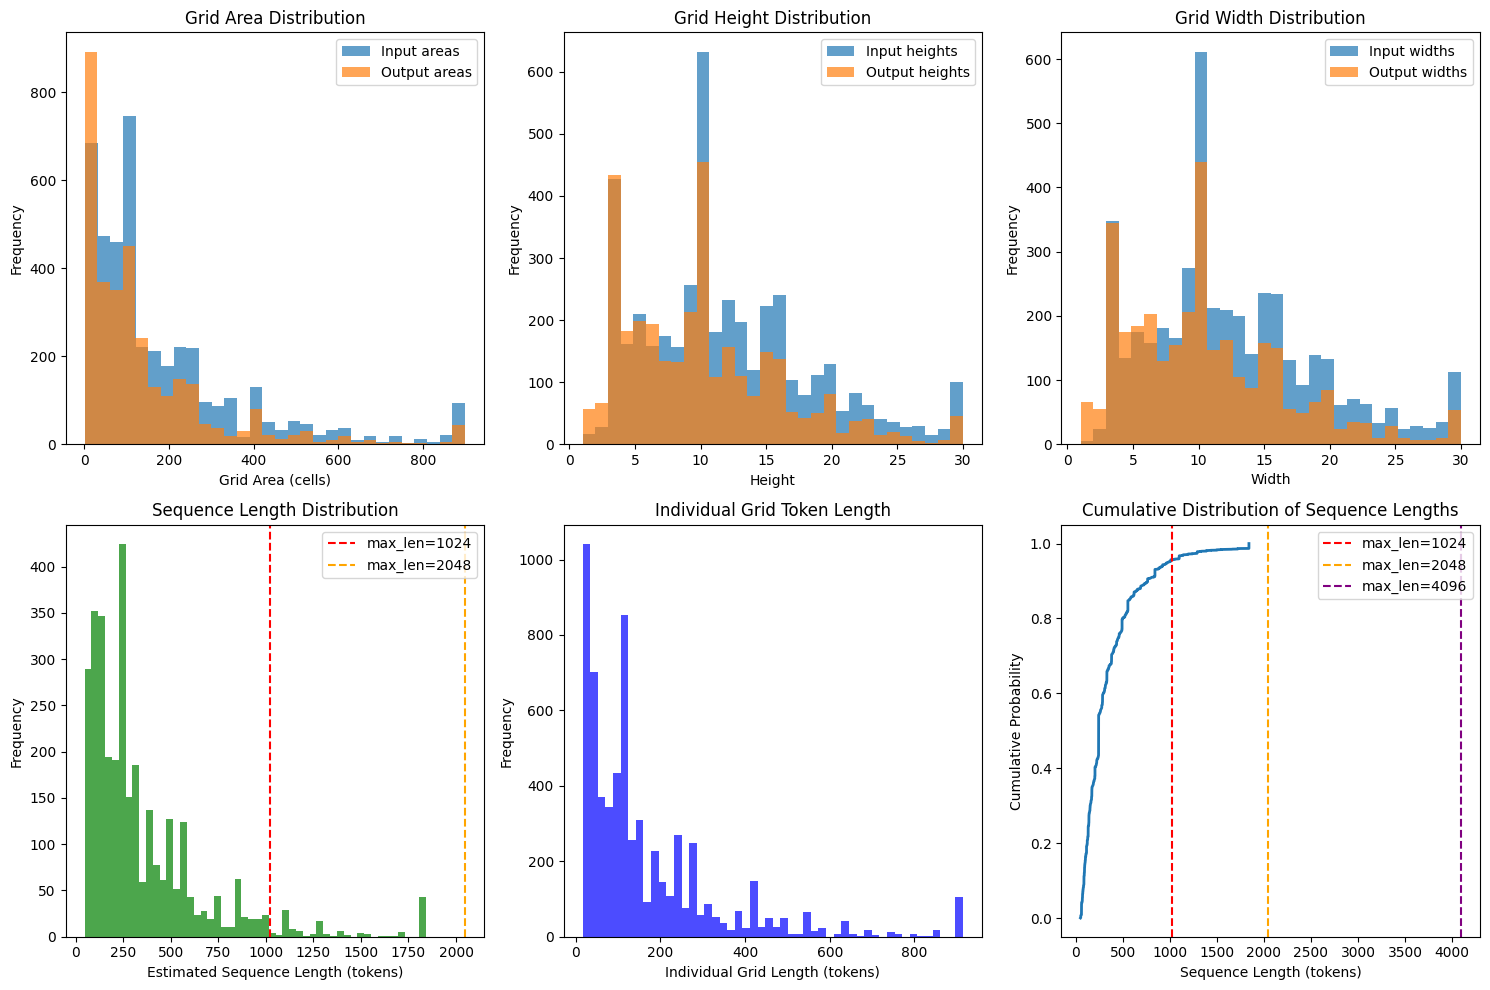

In [19]:
# Visualize distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Grid size distributions
plt.subplot(2, 3, 1)
plt.hist(grid_stats['input_areas'], bins=30, alpha=0.7, label='Input areas')
plt.hist(grid_stats['output_areas'], bins=30, alpha=0.7, label='Output areas')
plt.xlabel('Grid Area (cells)')
plt.ylabel('Frequency')
plt.title('Grid Area Distribution')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(grid_stats['input_heights'], bins=30, alpha=0.7, label='Input heights')
plt.hist(grid_stats['output_heights'], bins=30, alpha=0.7, label='Output heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Grid Height Distribution')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(grid_stats['input_widths'], bins=30, alpha=0.7, label='Input widths')
plt.hist(grid_stats['output_widths'], bins=30, alpha=0.7, label='Output widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Grid Width Distribution')
plt.legend()

# Token length distributions
plt.subplot(2, 3, 4)
plt.hist(seq_lengths, bins=50, alpha=0.7, color='green')
plt.xlabel('Estimated Sequence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.axvline(1024, color='red', linestyle='--', label='max_len=1024')
plt.axvline(2048, color='orange', linestyle='--', label='max_len=2048')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(grid_lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Individual Grid Length (tokens)')
plt.ylabel('Frequency')
plt.title('Individual Grid Token Length')

plt.subplot(2, 3, 6)
# Cumulative distribution
sorted_lengths = np.sort(seq_lengths)
y_vals = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, y_vals, linewidth=2)
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Sequence Lengths')
plt.axvline(1024, color='red', linestyle='--', label='max_len=1024')
plt.axvline(2048, color='orange', linestyle='--', label='max_len=2048')
plt.axvline(4096, color='purple', linestyle='--', label='max_len=4096')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Memory estimation and optimization recommendations
import torch

def estimate_memory_usage(batch_size, max_len, d_model=448, vocab_size=1000):
    """
    Estimate GPU memory usage for training.

    Args:
        batch_size: Training batch size
        max_len: Maximum sequence length
        d_model: Model dimension
        vocab_size: Vocabulary size

    Returns:
        Estimated memory usage in GB
    """
    # Model parameters (rough estimate)
    # Embeddings: vocab_size * d_model + max_len * d_model
    # Transformer blocks: approximately 12 * d_model^2 per layer (for 8 layers)
    # Output head: d_model * vocab_size

    embedding_params = (vocab_size + max_len) * d_model
    transformer_params = 8 * 12 * d_model * d_model  # 8 layers
    output_params = d_model * vocab_size

    total_params = embedding_params + transformer_params + output_params

    # Memory for parameters (4 bytes per float32)
    param_memory = total_params * 4 / 1e9  # GB

    # Memory for activations (rough estimate)
    # Forward pass: batch_size * max_len * d_model * layers * 4 bytes
    activation_memory = batch_size * max_len * d_model * 8 * 4 / 1e9  # GB

    # Gradients (same as parameters)
    gradient_memory = param_memory

    # Optimizer states (AdamW: 2x parameters)
    optimizer_memory = param_memory * 2

    total_memory = param_memory + activation_memory + gradient_memory + optimizer_memory

    return {
        'parameters': param_memory,
        'activations': activation_memory,
        'gradients': gradient_memory,
        'optimizer': optimizer_memory,
        'total': total_memory
    }

def get_hardware_recommendations():
    """Get training recommendations based on available hardware."""
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        gpu_name = torch.cuda.get_device_name(0)
    else:
        gpu_memory = 0
        gpu_name = "CPU"

    print(f"Hardware: {gpu_name}")
    print(f"Available memory: {gpu_memory:.1f} GB")

    # Generate recommendations
    configs = []

    for max_len in [512, 1024, 2048, 4096]:
        for batch_size in [4, 8, 16, 32]:
            memory_est = estimate_memory_usage(batch_size, max_len)

            if memory_est['total'] < gpu_memory * 0.9:  # 90% of available memory
                percentage_data = (seq_lengths <= max_len).mean() * 100
                configs.append({
                    'max_len': max_len,
                    'batch_size': batch_size,
                    'memory_gb': memory_est['total'],
                    'data_coverage': percentage_data
                })

    return configs

# Get recommendations
print("Generating hardware-specific recommendations...")
recommendations = get_hardware_recommendations()

print("\nRecommended Configurations:")
print("max_len | batch_size | memory (GB) | data coverage (%)")
print("-" * 55)

for config in recommendations[-10:]:  # Show top 10 configurations
    print(f"{config['max_len']:7d} | {config['batch_size']:10d} | {config['memory_gb']:11.2f} | {config['data_coverage']:13.1f}")

# Find optimal configuration
if recommendations:
    # Prefer configurations with high data coverage and reasonable memory usage
    best_config = max(recommendations, key=lambda x: x['data_coverage'] - x['memory_gb'] * 10)

    print(f"\nRecommended optimal configuration:")
    print(f"  max_len: {best_config['max_len']}")
    print(f"  batch_size: {best_config['batch_size']}")
    print(f"  Estimated memory usage: {best_config['memory_gb']:.2f} GB")
    print(f"  Data coverage: {best_config['data_coverage']:.1f}%")
else:
    print("\nWARNING: No configurations fit in available memory. Consider:")
    print("  - Using a smaller model")
    print("  - Reducing batch size further")
    print("  - Using gradient accumulation")

Generating hardware-specific recommendations...
Hardware: Tesla T4
Available memory: 15.8 GB

Recommended Configurations:
max_len | batch_size | memory (GB) | data coverage (%)
-------------------------------------------------------
   1024 |         16 |        0.56 |          95.7
   1024 |         32 |        0.80 |          95.7
   2048 |          4 |        0.45 |         100.0
   2048 |          8 |        0.57 |         100.0
   2048 |         16 |        0.81 |         100.0
   2048 |         32 |        1.28 |         100.0
   4096 |          4 |        0.59 |         100.0
   4096 |          8 |        0.82 |         100.0
   4096 |         16 |        1.29 |         100.0
   4096 |         32 |        2.23 |         100.0

Recommended optimal configuration:
  max_len: 2048
  batch_size: 4
  Estimated memory usage: 0.45 GB
  Data coverage: 100.0%


In [23]:
# Task complexity analysis
def analyze_task_complexity(tasks):
    """Analyze various complexity metrics of ARC tasks."""
    complexity_stats = {
        'num_train_pairs': [],
        'num_test_pairs': [],
        'color_diversity': [],
        'shape_changes': [],
        'size_changes': []
    }

    for task in tasks:
        # Number of training and test pairs
        complexity_stats['num_train_pairs'].append(len(task.get('train', [])))
        complexity_stats['num_test_pairs'].append(len(task.get('test', [])))

        # Analyze color diversity and transformations
        for train_pair in task.get('train', []):
            input_grid = train_pair['input']
            output_grid = train_pair['output']

            # Count unique colors
            input_colors = set()
            output_colors = set()

            for row in input_grid:
                input_colors.update(row)
            for row in output_grid:
                output_colors.update(row)

            complexity_stats['color_diversity'].append(len(input_colors | output_colors))

            # Check if grid size changes
            input_shape = (len(input_grid), len(input_grid[0]) if input_grid else 0)
            output_shape = (len(output_grid), len(output_grid[0]) if output_grid else 0)

            complexity_stats['shape_changes'].append(input_shape != output_shape)
            complexity_stats['size_changes'].append(
                (input_shape[0] * input_shape[1]) != (output_shape[0] * output_shape[1])
            )

    return complexity_stats

# Analyze task complexity
print("Analyzing task complexity...")
complexity_stats = analyze_task_complexity(training_tasks)

print("\nTask Complexity Statistics:")
for key, values in complexity_stats.items():
    if key in ['shape_changes', 'size_changes']:
        # Boolean values
        true_count = sum(values)
        percentage = (true_count / len(values)) * 100 if values else 0
        print(f"{key}: {true_count}/{len(values)} ({percentage:.1f}%)")
    else:
        # Numeric values
        if values:
            arr = np.array(values)
            print(f"{key}:")
            print(f"  Min: {arr.min()}, Max: {arr.max()}")
            print(f"  Mean: {arr.mean():.1f}, Median: {np.median(arr):.1f}")
            print()

Analyzing task complexity...

Task Complexity Statistics:
num_train_pairs:
  Min: 2, Max: 10
  Mean: 3.2, Median: 3.0

num_test_pairs:
  Min: 1, Max: 4
  Mean: 1.1, Median: 1.0

color_diversity:
  Min: 1, Max: 10
  Mean: 4.2, Median: 4.0

shape_changes: 1118/3232 (34.6%)
size_changes: 1118/3232 (34.6%)


In [24]:
# Training hyperparameter recommendations
def generate_training_recommendations(seq_lengths, gpu_memory_gb):
    """Generate comprehensive training recommendations."""

    print("TRAINING HYPERPARAMETER RECOMMENDATIONS")
    print("=" * 50)

    # Data coverage analysis
    print("\n1. SEQUENCE LENGTH ANALYSIS:")
    for max_len in [1024, 2048, 4096]:
        coverage = (seq_lengths <= max_len).mean() * 100
        excluded = len(seq_lengths) - (seq_lengths <= max_len).sum()
        print(f"   max_len={max_len}: {coverage:.1f}% coverage ({excluded} examples excluded)")

    # Memory-based recommendations
    print(f"\n2. MEMORY-BASED RECOMMENDATIONS (Available: {gpu_memory_gb:.1f}GB):")

    memory_configs = [
        (4096, 8, "Maximum coverage, high memory"),
        (2048, 16, "Good coverage, moderate memory"),
        (1024, 32, "Lower coverage, efficient memory"),
        (1024, 16, "Conservative, very stable")
    ]

    for max_len, batch_size, description in memory_configs:
        memory_est = estimate_memory_usage(batch_size, max_len)
        fits = "YES" if memory_est['total'] < gpu_memory_gb * 0.9 else "NO"
        coverage = (seq_lengths <= max_len).mean() * 100
        print(f"   max_len={max_len}, batch_size={batch_size}: {memory_est['total']:.2f}GB - {fits} ({description})")
        print(f"     Data coverage: {coverage:.1f}%")

    # Learning rate recommendations
    print("\n3. LEARNING RATE RECOMMENDATIONS:")
    print("   Base LR: 3e-4 (good starting point)")
    print("   For smaller batches (<16): Consider 1e-4 to 3e-4")
    print("   For larger batches (>16): Consider 3e-4 to 6e-4")
    print("   Use warmup: 1000-2000 steps")
    print("   Consider cosine decay for longer training")

    # Training duration recommendations
    print("\n4. TRAINING DURATION:")
    total_examples = len(seq_lengths)
    print(f"   Total training examples: {total_examples}")
    print("   Recommended steps:")

    for batch_size in [8, 16, 32]:
        epochs_10k = (10000 * batch_size) / total_examples
        epochs_50k = (50000 * batch_size) / total_examples
        print(f"     Batch size {batch_size}:")
        print(f"       10K steps = {epochs_10k:.1f} epochs")
        print(f"       50K steps = {epochs_50k:.1f} epochs")

    print("\n5. MODEL SIZE RECOMMENDATIONS:")
    print("   d_model=448: Good balance (current)")
    print("   d_model=512: Slightly larger, more capacity")
    print("   d_model=384: Smaller, faster training")
    print("   Consider n_layers=6-8 (current: 8)")

    print("\n6. OPTIMIZATION RECOMMENDATIONS:")
    print("   - Use gradient clipping (1.0)")
    print("   - Save best model based on validation loss")
    print("   - Monitor training/validation loss ratio")
    print("   - Use mixed precision training (already implemented)")
    print("   - Consider gradient accumulation if memory constrained")

# Generate recommendations
if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
else:
    gpu_mem = 8.0  # Assume 8GB for CPU/unknown

generate_training_recommendations(seq_lengths, gpu_mem)

TRAINING HYPERPARAMETER RECOMMENDATIONS

1. SEQUENCE LENGTH ANALYSIS:
   max_len=1024: 95.7% coverage (140 examples excluded)
   max_len=2048: 100.0% coverage (0 examples excluded)
   max_len=4096: 100.0% coverage (0 examples excluded)

2. MEMORY-BASED RECOMMENDATIONS (Available: 15.8GB):
   max_len=4096, batch_size=8: 0.82GB - YES (Maximum coverage, high memory)
     Data coverage: 100.0%
   max_len=2048, batch_size=16: 0.81GB - YES (Good coverage, moderate memory)
     Data coverage: 100.0%
   max_len=1024, batch_size=32: 0.80GB - YES (Lower coverage, efficient memory)
     Data coverage: 95.7%
   max_len=1024, batch_size=16: 0.56GB - YES (Conservative, very stable)
     Data coverage: 95.7%

3. LEARNING RATE RECOMMENDATIONS:
   Base LR: 3e-4 (good starting point)
   For smaller batches (<16): Consider 1e-4 to 3e-4
   For larger batches (>16): Consider 3e-4 to 6e-4
   Use warmup: 1000-2000 steps
   Consider cosine decay for longer training

4. TRAINING DURATION:
   Total training exa

In [25]:
# Export configuration for training
def export_training_config(seq_lengths, gpu_memory_gb, output_file="optimal_config.json"):
    """Export optimal training configuration as JSON."""

    # Determine optimal configuration
    if gpu_memory_gb > 20:  # A100/V100
        optimal_config = {
            "max_len": 2048,
            "batch_size": 16,
            "learning_rate": 3e-4,
            "steps": 50000,
            "d_model": 448
        }
    elif gpu_memory_gb > 14:  # T4
        optimal_config = {
            "max_len": 2048,
            "batch_size": 12,
            "learning_rate": 3e-4,
            "steps": 50000,
            "d_model": 448
        }
    else:  # Smaller GPUs
        optimal_config = {
            "max_len": 1024,
            "batch_size": 16,
            "learning_rate": 3e-4,
            "steps": 30000,
            "d_model": 384
        }

    # Add analysis results
    config_with_analysis = {
        "optimal_config": optimal_config,
        "analysis_results": {
            "total_examples": len(seq_lengths),
            "max_sequence_length": int(seq_lengths.max()),
            "mean_sequence_length": float(seq_lengths.mean()),
            "data_coverage_1024": float((seq_lengths <= 1024).mean() * 100),
            "data_coverage_2048": float((seq_lengths <= 2048).mean() * 100),
            "data_coverage_4096": float((seq_lengths <= 4096).mean() * 100),
            "gpu_memory_gb": gpu_memory_gb
        },
        "alternative_configs": [
            {"name": "memory_efficient", "max_len": 1024, "batch_size": 32, "learning_rate": 3e-4},
            {"name": "high_coverage", "max_len": 4096, "batch_size": 8, "learning_rate": 2e-4},
            {"name": "balanced", "max_len": 2048, "batch_size": 16, "learning_rate": 3e-4}
        ]
    }

    # Save to file
    import json
    with open(output_file, 'w') as f:
        json.dump(config_with_analysis, f, indent=2)

    print(f"Configuration saved to {output_file}")
    print(f"\nOptimal configuration for your hardware:")
    for key, value in optimal_config.items():
        print(f"  {key}: {value}")

    return config_with_analysis

# Export configuration
config = export_training_config(seq_lengths, gpu_mem)

print(f"\nSUMMARY:")
print(f"- Analyzed {len(training_tasks)} ARC training tasks")
print(f"- Found sequence lengths ranging from {seq_lengths.min()} to {seq_lengths.max()} tokens")
print(f"- Generated hardware-specific recommendations for {gpu_mem:.1f}GB GPU")
print(f"- Optimal configuration will train on {config['analysis_results']['data_coverage_2048']:.1f}% of data")
print(f"\nNext steps:")
print(f"1. Use the recommended configuration in your training script")
print(f"2. Monitor training and validation loss")
print(f"3. Adjust hyperparameters based on training progress")
print(f"4. Consider data augmentation with grid transformations")

Configuration saved to optimal_config.json

Optimal configuration for your hardware:
  max_len: 2048
  batch_size: 12
  learning_rate: 0.0003
  steps: 50000
  d_model: 448

SUMMARY:
- Analyzed 1000 ARC training tasks
- Found sequence lengths ranging from 48 to 1840 tokens
- Generated hardware-specific recommendations for 15.8GB GPU
- Optimal configuration will train on 100.0% of data

Next steps:
1. Use the recommended configuration in your training script
2. Monitor training and validation loss
3. Adjust hyperparameters based on training progress
4. Consider data augmentation with grid transformations
